# HERMAN FRANCLIN TESSO TASSANG

#Introduction to Modelling in epidemiology

## Task

Find a publication that applies Bayesian inference in the field of epidemiology, such as in spatial statistics or disease transmission modeling.

*    Identify which Bayesian methods (such as MCMC, VI, ABC, etc) and models were employed in the paper.

*    Determine the inference tools applied in the study, such as PPL usage, custom MCMC samplers, or specialized libraries.

*   Do you think the modelling part of the study could be improved or extended in some way?


## Answer:
One of such a publication is the paper by **Mariel et al.**; Publication Title: "[Bayesian Estimation of Population-Level Trends in Measures of Health Status](https://www.jstor.org/stable/43288446).

1. the Bayesian method used in the paper is *Markov Chain Monte Carlo (MCMC) *  within the framework of Beyasian hierachical modeling (model employed).

2. The inference tools: they employed Gibbs sampling and Metropolis-Hastings sampling, to simulate samples from the posterior distribution of parameters as well as the PPLs **BUGS** and **Stan**.
3. I think the study could be improved if we spend a little time on evaluating the **prior** to find a better informitive one as  it has a significant effect on the posterior distribution.

In [1]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 3.3 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp
import pandas as pd
from jax import random
# dsitributions
import numpyro
import numpyro.distributions as dist

from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import arviz as az
import matplotlib.pyplot as plt

import numpy as np

# Since we are using jax, we will need a random key:
rng = jax.random.PRNGKey(42)

# Probability Distributions and Random Variables

### Probability mass function
A *discrete* probability distribution can be uniquely defined by its <span style="color:orange">probability mass function (PMF)</span>.

For the Bernoulli distribution, we write the PMF as

\begin{align*}
p(X = x) = \mathcal{Bern}(X\mid p) &= \begin{cases}
p\, & \text{if } x = 1 \\
1 - p\, & \text{if } x = 0
\end{cases} \\
&= p^x(1-p)^{1-x}.
\end{align*}

## Task
Convince yourself that the two definitions of the Bernoulli distribution shown above are equivalent.

Now let's construct a Bernoulli distribution in code.

## Answer:
*   for $x=0$ ,  $p^0(1-p)^{1-0}=1-p=p(X = 0)$
*   for $ x=1,\  p^1(1-p)^{1-1}=p = p(X = 1)$

as expected, both definitions of the Bernoulli distribution are equivalent;

$$ p(X = x)= p^x(1-p)^{1-x},\quad x\in\{0,1\}$$

#### Visualise PMF

Now let's visualise the PMF:

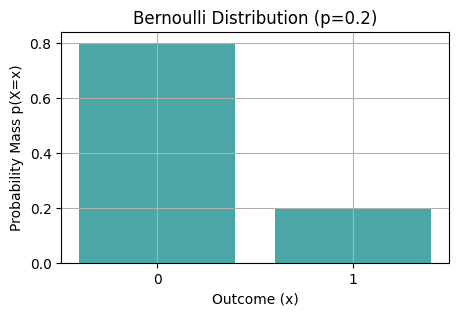

In [ ]:
def Bernouilli_vis(rng, p, n_samps):

    # define distribution
    bernoulli = dist.Bernoulli(probs=p)

    # collect samples
    samples = bernoulli.sample(key=rng, sample_shape=(n_samps,))

    # how many ones
    num_ones = (samples == 1.).sum()

    # how many zeros
    num_zeros = (samples == 0.).sum()

    # plot
    fig = plt.figure(dpi=100, figsize=(5, 3))
    ax = fig.add_subplot(1, 1,1)
    ax.bar([0, 1], [num_zeros/n_samps, num_ones/n_samps], alpha=0.7, color='teal')

    ax.set_xticks([0, 1])
    ax.set_xlabel('Outcome (x)')
    ax.set_ylabel('Probability Mass p(X=x)')
    ax.set_title(f'Bernoulli Distribution (p={p})')
    ax.grid(True)

    plt.show()

Bernouilli_vis(rng, p=0.2, n_samps=10)


## Task
Recreate this plot using `bernoulli.log_prob(sample)` functionality (see examples below).

## Answer:

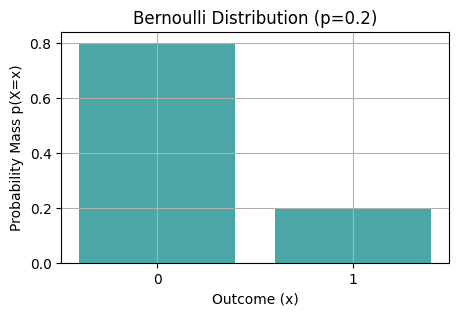

In [ ]:
p=0.2
# define distribution
bernoulli = dist.Bernoulli(probs=p)

 # sample: possible events {0,1}
sample =jnp.arange(0,2)

## compute probabilities using "bernoulli.log_prob(sample)"
prob_values=jnp.exp(bernoulli.log_prob(sample))

# plot
fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.bar([0, 1],prob_values, alpha=0.7, color='teal')

ax.set_xticks([0, 1])
ax.set_xlabel('Outcome (x)')
ax.set_ylabel('Probability Mass p(X=x)')
ax.set_title(f'Bernoulli Distribution (p={p})')
ax.grid(True)
plt.show()

## Task

Plot a panel of histograms where you vary probability
horizontally and number of samples
vertically. What do you observe?

## Answer:
We observe that when the number of sample increase, the probability value $\hat{p}$ given by the histogram deviate from the ground true probability of the distribution.

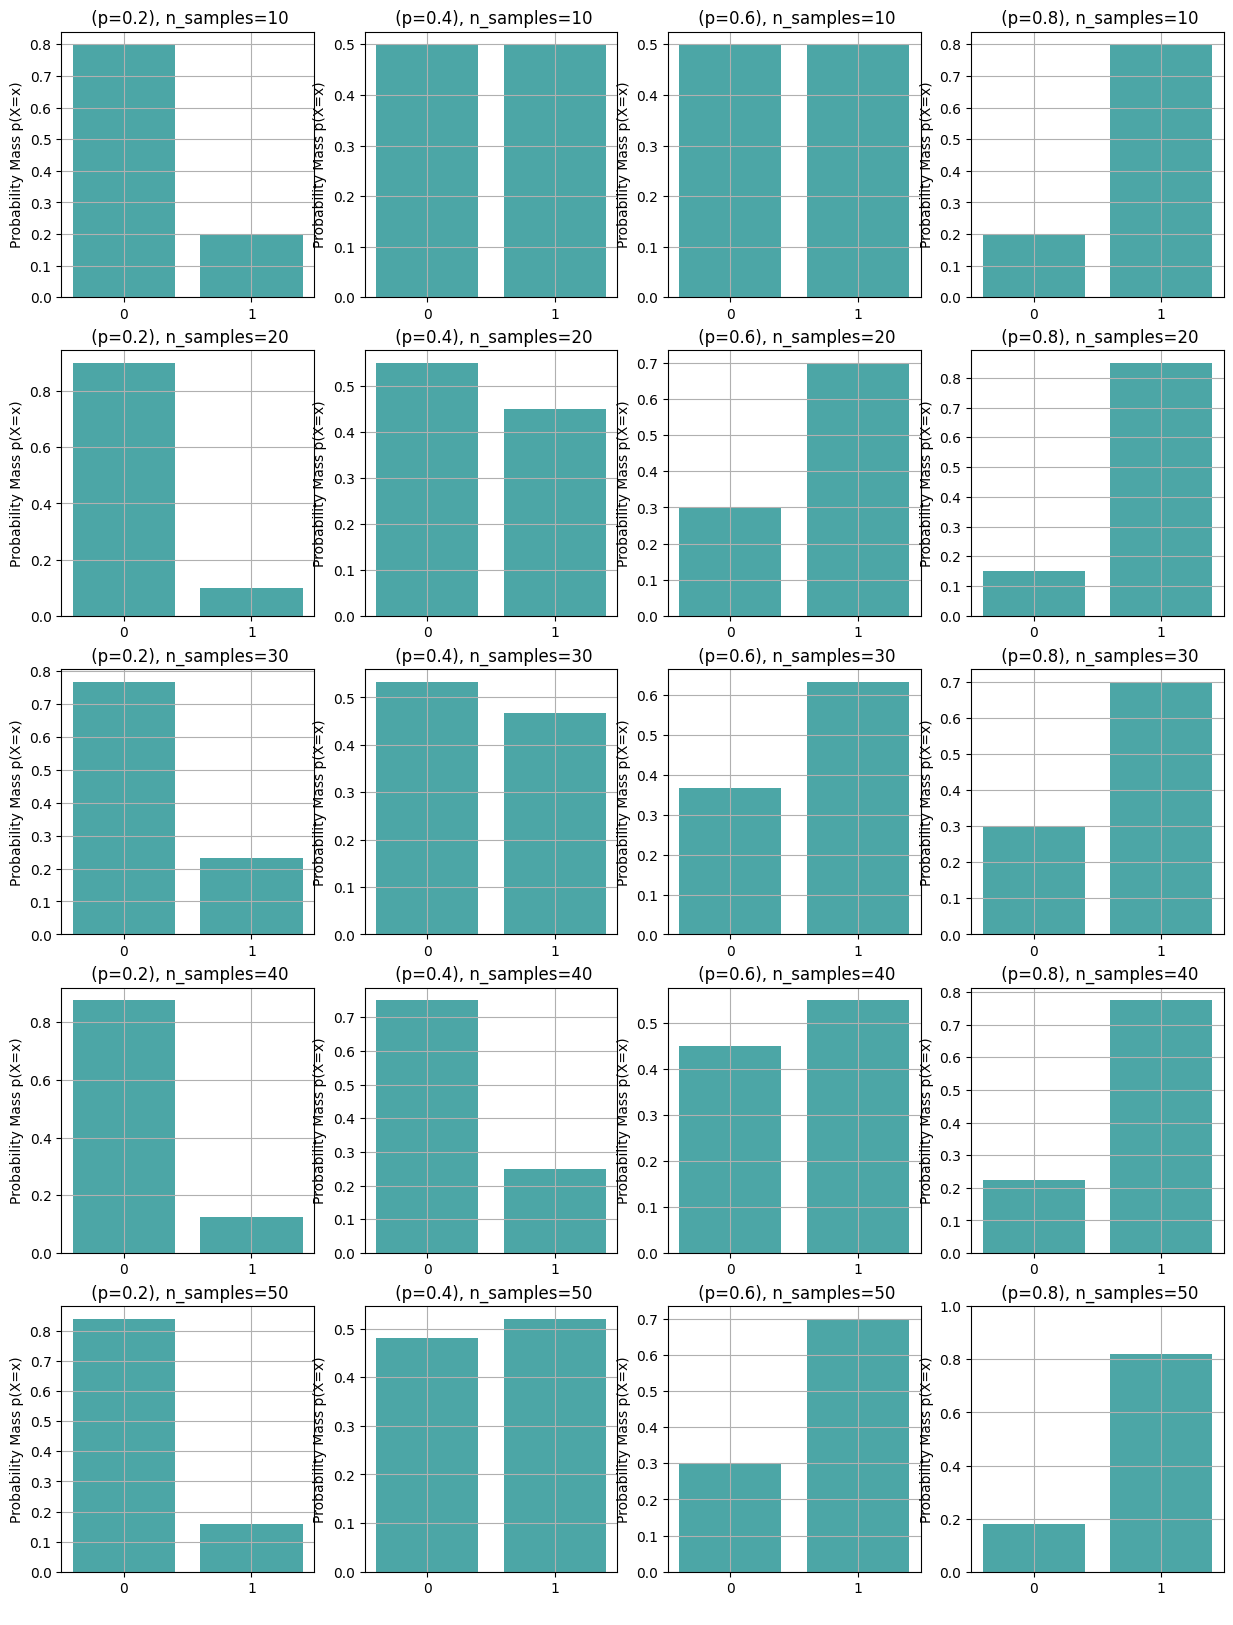

In [ ]:

fig,ax=plt.subplots(5,4,figsize=(15,20))

p =jnp.array([0.2, 0.4, 0.6, 0.8])
n_samps=jnp.arange(10,51,10)


for j in range(5):
  for i in range(4):
# define distribution
      bernoulli = dist.Bernoulli( probs=p[i])

    # collect samples
      samples = bernoulli.sample(key=rng, sample_shape=(n_samps[j],))

    # how many ones
      num_ones = (samples == 1.).sum()

    # how many zeros
      num_zeros = (samples == 0.).sum()
    # plot
      plt.ylim(0,1)
      ax[j,i].bar([0, 1], [num_zeros/n_samps[j], num_ones/n_samps[j]], alpha=0.7, color='teal')
      ax[j,i].set_xticks([0, 1])
      ax[j,i].set_xlabel(' ')
      ax[j,i].set_ylabel('Probability Mass p(X=x)')
      ax[j,i].set_title(f' (p={np.round(float(p[i]),decimals=2)}), n_samples={n_samps[j]}')
      ax[j,i].grid(True)


### The Binomial distribution

#### Probability mass function

The PMF of the Bernoulli distribution is

$$P(X = x) = \binom{n}{x} p^x (1 - p)^{n - x},$$

where

- $P(X = x)$ is the probability of getting exactly $x$ successes,

- $\binom{n}{x}$ is the binomial coefficient, representing the number of ways to choose $x$ successes out of $n$ trials,

- $p$ is the probability of success on a single trial,

- $1-p$ is the probability of failure on a single trial,

- the bnumber of successes $x$ ranges from $0$ to $n$ inclusive.


## Task
Compute
 $\sum_{x=0}^n P(X=x)$.


## Answer:
\begin{align*}
 \sum_{x=0}^n P(X=x)&=\sum_{x=0}^n\binom{n}{x} p^x (1 - p)^{n - x}\quad (\textit{we notice binomial expansion} )\\
 &=\big( p+(1-p)\big)^{n}=1
 \end{align*}

 Thus, $$\sum_{x=0}^n P(X=x)=1$$

## Task

Draw several samples from this distribution using different keys. And draw repeatedly several samples with the same key. What do you conclude about the role of key in reproducibility of numerical experiments?

## Answer:
We conclude that using the same key at each generation result of the samples to be the exact replicate of the samples firstly obtained with that key, Whereas different key  may provide differents samples.

so by using the same key,  we insure reproductibility of the samples.

In [ ]:
# list of keys
keys=[42,88,128,180]

p = 0.3
n = 10
binomial = dist.Binomial(total_count=n, probs=p)

## draw samples Using the same key
print(' samples with the same key ')
sample = binomial.sample(jax.random.PRNGKey(keys[0]), sample_shape=(20,))
print(sample)
sample = binomial.sample(jax.random.PRNGKey(keys[0]), sample_shape=(20,))
print(sample)
sample = binomial.sample(jax.random.PRNGKey(keys[0]), sample_shape=(20,))
print(sample)

print('')
#Draw samples using differents keys

print('')
print('samples from different keys')
sample = binomial.sample(jax.random.PRNGKey(keys[1]), sample_shape=(20,))
print(sample)
print('')
sample = binomial.sample(jax.random.PRNGKey(keys[2]), sample_shape=(20,))
print(sample)
print('')
sample = binomial.sample(jax.random.PRNGKey(keys[3]), sample_shape=(20,))
print(sample)


 samples with the same key 
[4 2 5 1 5 4 4 4 4 4 4 3 3 4 1 2 2 2 1 2]
[4 2 5 1 5 4 4 4 4 4 4 3 3 4 1 2 2 2 1 2]
[4 2 5 1 5 4 4 4 4 4 4 3 3 4 1 2 2 2 1 2]


samples from different keys
[4 2 5 2 1 1 2 2 4 7 2 4 2 3 3 4 2 3 4 5]

[3 4 2 4 3 5 3 1 3 3 2 2 1 1 1 2 5 2 5 4]

[5 1 4 2 4 3 2 3 4 3 3 1 1 1 3 5 3 3 2 4]


## Visualise PMF

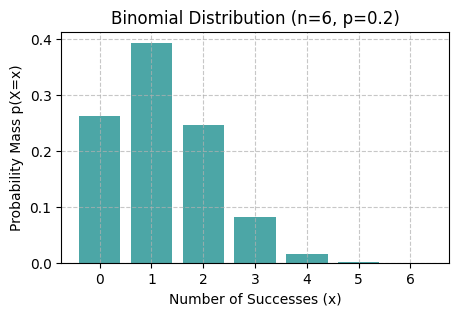

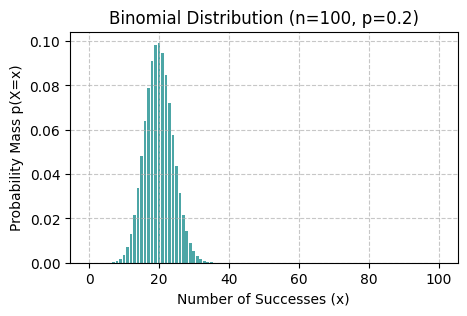

In [ ]:
def binomial_vis(rng, p, n, x_ticks=True):

    # Binomial distribution with n trials and probability of success p
    binomial = dist.Binomial(total_count=n, probs=p)

    # Generate the possible outcomes (x values)
    x_values = jnp.arange(0, n + 1)

    pmf_values = jnp.exp(binomial.log_prob(x_values))

    # Create a bar plot (PMF plot)
    fig = plt.figure(dpi=100, figsize=(5, 3))
    plt.bar(x_values, pmf_values, align='center', alpha=0.7, color='teal')
    plt.xlabel('Number of Successes (x)')
    plt.ylabel('Probability Mass p(X=x)')
    plt.title(f'Binomial Distribution (n={n}, p={p})')
    if x_ticks:
        plt.xticks(x_values)
    plt.grid( linestyle='--', alpha=0.7)

    plt.show()
binomial_vis(rng, p=0.2, n=6)
binomial_vis(rng, p=0.2, n=100, x_ticks=False)

## Task
What is qualitatively different between the shapes of distributions `Binomial(p=0.2, n=6)` and `Binomial(p=0.2, n=100)`?

## Answer:
 for '$Binomial(p=0.2,n=100)\ $' the shape roughly look like the one of  a gaussian density center at $m=20$ (location or average number of successes); whereas  $Binomial(p=0.2,n=6)\ $ has an average number of successes of $m=1$.

### The Categorical distribution
$$
\begin{align*}
p(X = x) = \mathcal{Categorical}(X \mid p) = \prod_{k=1}^K p_k^{I_{x=k}},
\end{align*}
$$

## Task
Explain why a categorical distribution with $K = 2$ is equivalent to a Bernoulli distribution.

## Answer:

$K=2⟹ two\ possible\ outcomes\ \{ 1,2 \};\ P=[ p_1,p_2 ]$.
 Moreover,
$p_1+p_2=1⟹p_2=1-p_1$

using the formula, we have

$p(X = 1) = \mathcal{Categorical}(X \mid p) =p_1\ and\ p(X = 2) = \mathcal{Categorical}(X \mid p) =p_2=1-p_1$.

Wich is precisely the caracterisation of a Bernoulli distribution $\mathcal{Bern}(X\mid p_1)$.

# **Continu Distribution**


### The Beta distribution

The Beta distribution is a continuous distribution with support in $[0,1] \subset \mathbb{R}$.
The Beta distribution can be used to describe a continuous random variable between 0 and 1, for example, percentages and ratios. It has the following form

$$
p(X = x) = \mathcal{Beta}(x|\alpha,\beta) = \frac{1}{\mathrm{B}(\alpha,\beta)}x^{\alpha-1}(1 - x)^{\beta - 1},
$$

where $\alpha > 0$ and $\beta > 0$ are the two <font color='orange'>shape</font> parameters of the distribution, and $\mathrm{B}$ is called the beta function.

Let's visualise the distribution.

## Task

* Try making each parameter big or small while leaving the other at the same value.
* Then try make them both big or small.


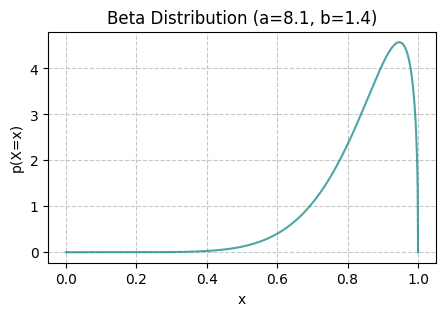

In [ ]:
#@title Answer ( interactif ): {run:"auto"}
a=8.1 #@param {type:"slider", min:0.1, max:10, step:0.1}
b=1.4 #@param {type:"slider", min:0.1, max:10, step:0.1}
def beta_vis(a, b, x_ticks=True):

    beta = dist.Beta(a, b)

    x_values = jnp.linspace(0, 1, 1000)

    pmf_values = jnp.exp(beta.log_prob(x_values))

    fig = plt.figure(dpi=100, figsize=(5, 3))
    plt.plot(x_values, pmf_values, alpha=0.7, color='teal')
    plt.xlabel('x')
    plt.ylabel('p(X=x)')
    plt.title(f'Beta Distribution (a={a}, b={b})')
    if x_ticks:
        plt.xticks(x_values)
    plt.grid( linestyle='--', alpha=0.7)

    plt.show()

beta_vis(a, b, x_ticks=False)

### The Normal distribution


$$
p(X = x) = \mathcal{N}(x\mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(\mu - x)^2}{2\sigma^2}\right),
$$

where $\mu$ and $\sigma$ are the <font color='orange'>mean</font> and <font color='orange'>standard deviation</font> (also called the location, and scale or square-root of the <font color='orange'>variance</font> $\sigma^2$, respectively).

## Task
How do the mean and standard deviation affect the samples?


## Answer:
* The mean $\mu$ indicates where the peak of the distribution occurs; i.e the most probable location to sample a value. Changing the mean shifts the entire distribution along the $x-axis$.
* A large Standard deviation $\sigma$ results in a more spread-out distribution, while smaller standard deviation leads to a narrower distribution. Thus the Standard deviation control the width of the distribution.

## Task
Implement the PDF of the Normal dsitribution and test it using the function provided below.

In [ ]:
#@title Answer:

def normal_pdf(loc, scale, x):
    p_x =(1/jnp.sqrt(2*jnp.pi*scale**2))*jnp.exp((-1/2)*((x-loc)/scale)**2)  # TODO: your code goes here!

    return p_x

  ### Test

def test_normal_pdf(pdf_fn, run=False):
  if not run:
    return
  assert pdf_fn(0, 1, 0) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(0)), "Normal(X=0|0, 1) is incorrect."
  assert pdf_fn(0, 2, 0) == jnp.exp(dist.Normal(loc=0, scale=2).log_prob(0)), "Normal(X=0|0, 2) is incorrect."
  assert pdf_fn(0, 1, 1) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(1)), "Normal(X=0|1, 1) is incorrect."
  assert pdf_fn(2, 3, 1) == jnp.exp(dist.Normal(loc=2, scale=3).log_prob(1)), "Normal(X=1|2, 3) is incorrect."
  print("Nice! Your answer looks correct.")

test_normal_pdf(normal_pdf, run=True)

Nice! Your answer looks correct.


## The Multivariate Normal distribution


The PDF for an $D$-dimensional random variable $X$:

$$
p(X = x) = \mathcal{N}(x\mid \mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^D|\Sigma|}}\exp\left(-\frac{1}{2}(x - \mu)^\intercal\Sigma^{-1}(x - \mu)\right),
$$

where $x$ and $\mu$ are now vectors of numbers rather than single numbers, $\Sigma$ is a <font color='orange'>covariance matrix</font> that replaces $\sigma$ from our univariate definition above, and $|\Sigma|$ is its determinant. The covariance matrix looks like this:
\begin{equation*}
\Sigma = \begin{bmatrix}\sigma_1^2 & \rho_{12} \sigma_1 \sigma_2 & \cdots &  \rho_{1D} \sigma_1 \sigma_D  \\
    \rho_{21} \sigma_2\sigma_1 & \sigma_2^2 & \cdots &  \rho_{2D} \sigma_2 \sigma_D \\
    \vdots & \vdots & \ddots & \vdots \\
    \rho_{D1} \sigma_D \sigma_1 & \rho_{D2} \sigma_D \sigma_2 & \cdots & \sigma_D^2 \end{bmatrix}
\end{equation*}

where $\sigma_i^2$ is the variance for the $i$-th dimension, and $\rho_{ij} = \rho_{ji}$ is the *correlation* between the $i$-th and $j$-th dimensions. The covariance matrix tells us how the "ball" of random variables is stretched and rotated in space.

## Task
Show that the equation above is equivalent to the univariate case when $D = 1$

## Answer:
when $D=1\ $, $\ \Sigma=\sigma^2,\  \ x,\mu \in \mathbb{R},\ \ (x-\mu)^{T}\Sigma^{-1}(x-\mu)=\frac{(x-\mu)^{2}}{\sigma^{2}}$. Therefore,


$$ p(X = x)= \frac{1}{\sqrt{(2\pi)^D|\Sigma|}}\exp\left(-\frac{1}{2}(x - \mu)^\intercal\Sigma^{-1}(x - \mu)\right)$$

$$=\frac{1}{\sqrt{(2\pi)\sigma^2}}\exp\left(-\frac{1}{2}\frac{(x-\mu)^{2}}{\sigma^{2}}\right)$$

we retrieve the unit variate case as required.



### Measuring distances between distributions

- Kullback-Leibler Divergence (KLD): Also known as relative entropy, measures the information lost when one probability distribution is used to approximate another. It is asymmetric, and, hence is not a 'distance' but a 'deviance'

$$
\text{KLD}(p \parallel q) = \int p(x) \log \left( \frac{p(x)}{q(x)} \right) \, dx=\mathbb{E}_{x\sim p(X)}\left[\log\frac{p(x)}{q(x)}\right].
$$



In [ ]:
#@title 1. Implement numeric evaluation of the KL divergence.


def kl_divergence(p: dist.Distribution, q: dist.Distribution, n: int = 10_000):
  # draw n samples from the distribution P
    samples = p.sample(rng, sample_shape = (n,))

    # compute the Log probabilies
    p_log_probs = p.log_prob(samples)
    q_log_probs = q.log_prob(samples)
    # return the KL divergence value
    return (p_log_probs - q_log_probs).mean()


2. Calculate the following KL divergence. What do we see?
    - $\mathrm{KLD}\left[\mathrm{Uniform}(0, 1) \mid\mid \mathrm{Uniform}(0, 1)\right]$
    - $\mathrm{KLD}\left[\mathrm{Beta}(5, 2) \mid\mid \mathrm{Beta}(5, 2)\right]$

3. Calculate the following KL divergences. What can we say about the relationship between the beta and uniform distributions?
    - What is $\mathrm{KLD}\left[\mathrm{Uniform}(0, 1) \mid\mid \mathrm{Beta}(5, 2)\right]$?
    - What is $\mathrm{KLD}\left[\mathrm{Uniform}(0, 1) \mid\mid \mathrm{Beta}(2, 2)\right]$?
    - What is $\mathrm{KLD}\left[\mathrm{Uniform}(0, 1) \mid\mid \mathrm{Beta}(1, 1)\right]$?

4. What is $\mathrm{KLD}\left[ \mathrm{Beta}(5, 2) \mid\mid \mathrm{Uniform}(0, 1)\right]$. How does it compare to $D_\mathrm{KL}\left[\mathrm{Uniform}(0, 1) \mid\mid \mathrm{Beta}(5, 2)\right]$ from above?

5. Compare $\mathrm{KLD}\left[\mathrm{Uniform}(-1, 1) \mid\mid \mathcal{N}(0, 1)\right]$ and $D_\mathrm{KL}\left[\mathcal{N}(0, 1) \mid\mid  \mathrm{Uniform}(-1, 1) \right]$.



##Answer:

2. the both KLD are $0$. we notice that the KLD divergence of two identical distribution is $0$.
3. As the  parameters ($\alpha,\ \beta$ ) of the beta distribution approach (1,1), the KL divergence decreases. Eventually, when both  parameters are 1, the KL divergence becomes approximately 0. This indicates that the Beta(1,1) distribution is uniform between 0 and 1.
4. $D_\mathrm{KL}\left[ \mathrm{Beta}(5, 2) \mid\mid \mathrm{Uniform}(0, 1)\right] \ne D_\mathrm{KL}\left[ \mathrm{Uniform}(0, 1) \mid\mid \mathrm{Beta}(5, 2)\right]$, The KLD is not symmetric.
5. $\mathrm{KLD}\left[\mathrm{Uniform}(-1, 1) \mid\mid \mathcal{N}(0, 1)\right]$ is positive whereas $D_\mathrm{KL}\left[\mathcal{N}(0, 1) \mid\mid  \mathrm{Uniform}(-1, 1) \right]$ is negative.


In [ ]:
## define the distributions
# Uniform(0,1)
uniform_1=dist.Uniform(low=0,high=1)
# Uniform(-1,1)
uniform_2=dist.Uniform(low=-1,high=1)
# Beta(5,2 )
beta_1=dist.Beta(5,2)
# Beta(2,2)
beta_2=dist.Beta(2,2)
# Beta(1,1)
beta_3=dist.Beta(1,1)
# Normal(0,1)
normal=dist.Normal(0,1)

# 2)
print(f"DKL[Uniform(0,1)||Uniform(0,1)]={kl_divergence(p=uniform_1,q=uniform_1)}")
print('')
print(f"DKL[Beta(5,2)||Beta(5,2)]={kl_divergence(p=beta_1,q=beta_1)}")
print('')

#3)
print(f"DKL[Uniform(0,1)||Beta(5,2)]={kl_divergence(p=uniform_1,q=beta_1)}")
print('')
print(f"DKL[Uniform(0,1)||Beta(2,2)]={kl_divergence(p=uniform_1,q=beta_2)}")
print('')
print(f"DKL[Uniform(0,1)||Beta(1,1)]={kl_divergence(p=uniform_1,q=beta_3)}")

# 4)
print('')
print(f"DKL[Beta(5,2)||Uniform(0,1)]={kl_divergence(p=beta_1,q=uniform_1)}")
# 5)
print('')
print(f"DKL[Uniform(-1,1)||Normal(0,1)]={kl_divergence(p=uniform_2,q=normal)}")
print('')
print(f"DKL[Uniform(-1,1)||Normal(0,1)]={kl_divergence(p=normal,q=uniform_2)}")

DKL[Uniform(0,1)||Uniform(0,1)]=0.0

DKL[Beta(5,2)||Beta(5,2)]=0.0

DKL[Uniform(0,1)||Beta(5,2)]=-0.48455995321273804

DKL[Uniform(0,1)||Beta(2,2)]=-0.12443127483129501

DKL[Uniform(0,1)||Beta(1,1)]=9.5367431640625e-07

DKL[Beta(5,2)||Uniform(0,1)]=-1.6500688791275024

DKL[Uniform(-1,1)||Normal(0,1)]=0.7362034320831299

DKL[Uniform(-1,1)||Normal(0,1)]=-0.39463376998901367


#Bayesian Inference


## Task

Consider the coin flipping problem with probability of heads ('success') being modelled as $p$. The experiment was repeated $n$ times, and we observed $h$ 'sucesses'. Assume that the coin flips follow the Bernoulli distribution $\mathcal{Bern}(p)$.

- Derive the <font color='orange'>maximum likelihood estimate (MLE)</font> for parameter $p$

$$
\hat{\theta}_\text{MLE} = {\arg \max}_\theta p(y | \theta)
$$

- How does the amount of data affect the MLE estimate?

- Derive the <font color='orange'>maximum aposteriori estimate (MAP)</font> for parameter $p$, using a $\mathcal{Beta}(a,b)$ prior

$$
\hat{\theta}_\text{MAP} = {\arg \max}_\theta p(y | \theta)p(\theta)
$$

- How does the amount of data and parameters of the Beta distribution affect the MLE estimate?

- Visualise MAP as a function of $n, h, a, b$.

- What is the difference between the two approaches?  Does a point estimate tell us anything about our uncertainty or the distribution from which we draw the estimate?

## Answer:
1. the $ p(y | \theta)=p(y_1,...,y_n|\theta)=\prod_{i=1}^{n}\theta^{y_i}(1-\theta )^{1-y_i}=\theta^{\sum_{i}^{n} y_i}(1-\theta )^{n-\sum_{i}^{n} y_i}=\theta^h(1-\theta )^{n-h}$.

maximize $ p(y | \theta)$ is equivalent to maximize $\log p(y | \theta)$ ( $ log(x) is a concave function). Thus setting the derivative to 0, we obtain:

$\frac{\partial }{\partial \theta}logp(y | \theta)=0 \Longrightarrow \frac{h}{\theta}-\frac{n-h}{1-\theta}=0\ \Longrightarrow \hat \theta_{MLE}=\frac{h}{n}$
2. as the amount of data increase, the MLE estimate get smaller.

3. Derive the MAP: $p(y | \theta)p(\theta)=\theta^h(1-\theta )^{n-h}\frac{\theta^{a-1} (1-\theta )^{b-1}}{\beta(a,b)}=\frac{\theta^{h+a-1}(1-\theta )^{n-h+b-1}}{\beta(a,b)}$. as previously we wan maximize the $log(p(y | \theta)p(\theta))$ to get the result.

$\frac{\partial }{\partial \theta}log(p(y | \theta)p(\theta))=0 \Longrightarrow \frac{h+a-1}{\theta}-\frac{n-h+b-1}{1-\theta}=0\ \Longrightarrow \hat \theta_{MAP}=\frac{h+a-1}{n+a+b-2}$
4. The MAP estimate is higly affected by the parameter $a, b$ of the prior:
* when $a$ and $b$ are exactly 1, whe retrieve the MLE estimate.
* when the amount of data $n$ increase, and the proportion number of sucess $h$ is close to $n$, the different between MAP and MLE become significant.
* The MAP can be seen as a penalized version of the MLE estimate.
* when a is greater than b , the MAP tend to shift to the left ( less than the MLE) and conversely, when b is greater than a, it tends to shitf to the right ( greater than the MLE).

5. visualize
6. The difference between the two approach is that, MLE is a point estimate that rely only on observations to find the assume unknown parameter.Whereas the MAP despite being  a point estimate as well, it take into account our initial guest (prior distribution).therefore MAP is biased by the prior we choose.

The point estimate does not inform us about the distribution from which we draw the estimate, it just assume that there is an unknow groundtruth parameter value we want to find.


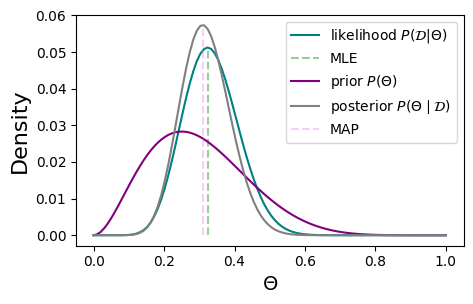

In [ ]:
#@title visualize the MAP (interactif) {run: "auto"}

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

n = 34 #@param {type:"slider", min:1, max:100, step:1}
h = 11 #@param {type:"slider", min:0, max:100, step:1}
a = 3 #@param {type:"slider", min:0, max:10, step:1}
b = 7 #@param {type:"slider", min:0, max:10, step:1}

# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood= jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))
# Bayesian
# prior, then normalise
log_prob_prior = dist.Beta(a, b).log_prob(p_grid)
prior = jnp.exp(log_prob_prior - jnp.max(log_prob_prior)) / jnp.sum(jnp.exp(log_prob_prior - jnp.max(log_prob_prior)))
# posterior, then normalise
log_prob_post = dist.Beta(a+h, b+n-h).log_prob(p_grid)
post = jnp.exp(log_prob_post - jnp.max(log_prob_post)) / jnp.sum(jnp.exp(log_prob_post - jnp.max(log_prob_post)))

fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(p_grid, likelihood,color='teal',label='likelihood $P(\mathcal{D}|\Theta)$')
ax.vlines(h/n, 0, max(likelihood),color='green',label='MLE',linestyle='--',alpha=0.4)
ax.plot(p_grid, prior, label='prior $P(\Theta)$', c='purple')
ax.plot(p_grid, post, label='posterior $P(\Theta \mid \mathcal{D})$', c='gray')
ax.vlines((h + a - 1)/(n + a + b - 2),0, max(post), color='violet', linestyle='dashed', alpha=0.4, label='MAP')
ax.set_xlabel('$\Theta$', fontsize=14)
ax.set_ylabel('Density', fontsize=16)
ax.legend()
plt.show()

# Introduction On Numpyro


In [ ]:
def model(data):

    # Define prior distributions for model parameters
    mean = numpyro.sample("mean", dist.Normal(0, 1))
    scale = numpyro.sample("scale", dist.Exponential(1))

    # Define likelihood with a data plate
    with numpyro.plate("data_plate", len(data)):
        obs = numpyro.sample("obs", dist.Normal(mean, scale), obs=data)


nuts_kernel = NUTS(model)

# data
data = jnp.array([2.3, 3.9, 1.7, -0.8, 2.5])

mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=2, chain_method='parallel', progress_bar=False)
mcmc.run(jax.random.PRNGKey(0), data)

# Get the posterior samples
posterior_samples = mcmc.get_samples()

# Print summary statistics of posterior
mcmc.print_summary()

<ipython-input-14-db2e9c973611>:17: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=2, chain_method='parallel', progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      mean      1.17      0.69      1.19      0.04      2.27    885.10      1.01
     scale      1.87      0.62      1.74      0.97      2.72    783.04      1.00

Number of divergences: 0


In [ ]:
posterior_samples

{'mean': Array([1.613232  , 0.94773185, 0.81084955, ..., 1.391619  , 2.3862965 ,
        1.1810328 ], dtype=float32),
 'scale': Array([2.5492907, 4.0142484, 3.8005872, ..., 1.3023396, 2.1564028,
        1.3255814], dtype=float32)}

## Task
- You might have correctly noticed that we have not looked at the `Predictive` capability. Study the documentation of Numpyro (in particular, `numpyro.infer`) and demonstrate the `Predictive` command on the example shown above.
- Study the documentation of Numpyro (in particular, `numpyro.diagnostics`) to understand what the `hpdi` command does. Apply it to the example shown above.

## Answer


*   the predictive command 'Predictive' from 'numpyro.infer' is use to construct predictive distribution. It is obtain by running model conditioned by samples from posterior
*   the command 'hdip' (Highest posterior density Interval) from the 'numpyro.diagnostics' is used to obtain the narrowest interval with probability mass 'p'  specify in the 'prob' argument. It give a range of value in which a certain percentage (prob) of the posterior distribution lies.


In [ ]:
## Demonstrate the predictive command
predict=Predictive(model,posterior_samples=posterior_samples )
y_pred=predict( jax.random.PRNGKey(0),data)
print(y_pred)

print('')

# Apply the hdpi command

## hpdi_mean (95% credibility interval for mean parameter)
hpdi_mean=hpdi(posterior_samples['mean'],prob=0.95)
print(f"95% credibility interval for mean parameter :  {hpdi_mean}")

print('')

## hpdi_mean (95% credibility interval for mean parameter)
hpdi_scale=hpdi(posterior_samples['scale'],prob=0.95)
print(f"95% credibility interval for scale parameter :  {hpdi_scale}")

{'obs': Array([[ 2.3,  3.9,  1.7, -0.8,  2.5],
       [ 2.3,  3.9,  1.7, -0.8,  2.5],
       [ 2.3,  3.9,  1.7, -0.8,  2.5],
       ...,
       [ 2.3,  3.9,  1.7, -0.8,  2.5],
       [ 2.3,  3.9,  1.7, -0.8,  2.5],
       [ 2.3,  3.9,  1.7, -0.8,  2.5]], dtype=float32)}

95% credibility interval for mean parameter :  [-0.16720782  2.4644678 ]

95% credibility interval for scale parameter :  [0.97064567 3.145492  ]


# Focus on Prior

## Influnce of the Prior

In [ ]:
##############################################
# prior x likelihood = posterior
##############################################

h=6
n=9
p=h/n

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood_pmf = jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))


##############
def computePosterior(likelihood, prior):
    # this function computes posterior
    # and plots the result

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize posterior
    posterior = unstd_posterior / unstd_posterior.sum()

    plt.figure(figsize=(17, 3))
    ax1 = plt.subplot(131)
    ax1.set_title("Prior")
    ax1.grid(0.3)
    plt.plot(p_grid, prior,color='purple')

    ax2 = plt.subplot(132)
    ax2.set_title("Likelihood")
    ax2.grid(0.3)
    plt.plot(p_grid, likelihood,color='teal')

    ax3 = plt.subplot(133)
    ax3.set_title("Posterior")
    plt.plot(p_grid, posterior,color='orangered')
    ax3.grid(0.3)
    plt.show()

    return

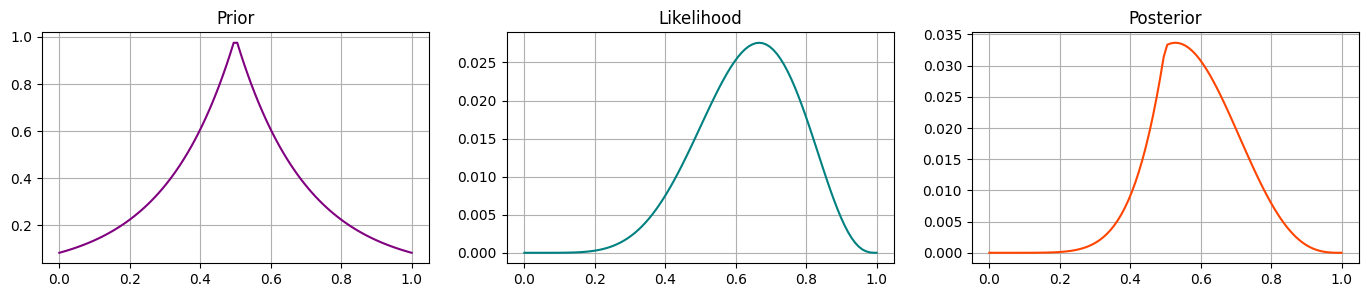

In [ ]:
prior3 = jnp.exp(- 5 * abs(p_grid - 0.5))
posterior3 = computePosterior(likelihood_pmf, prior3)

# Task
implement a Beta prior for this case with parameters $a, b$
. How does posterior depend on these parameters?

## Answer:
The values of a and b determine the shape of the posterior distribution. Specifically, a shapes the distribution near 0 (left side), while b shapes the distribution near 1 (right side). If a and b are both relatively small, the distribution will be U-shaped, with higher probability density in the middle. As a and b increase, the distribution becomes more peaked and concentrated towards 0 or 1, depending on their relative values.

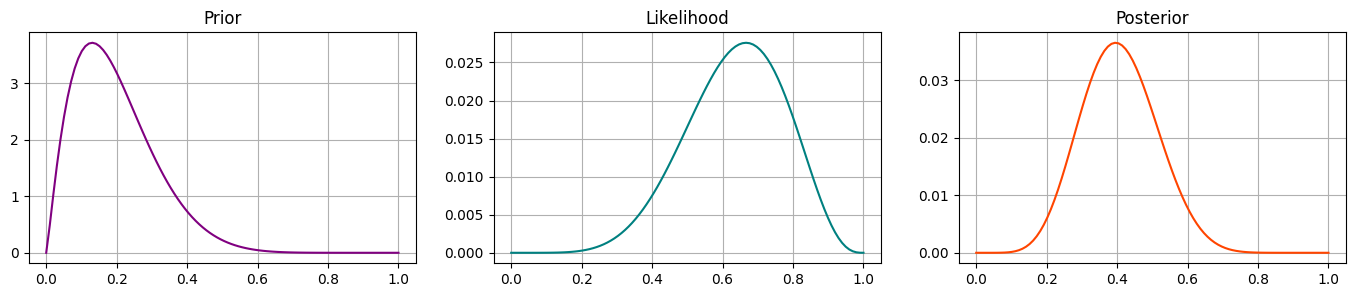

In [ ]:
#@title implementation (interactif slider) {run:"auto"}
a=2.2 #@param {type:"slider", min:0.1, max:10, step:0.1}
b=9 #@param {type:"slider", min:0.1, max:10, step:0.1}
# Beta(a,b) Prior
prior4=jnp.exp(dist.Beta(a,b).log_prob(p_grid))
posterior4=computePosterior(likelihood_pmf,prior4)

# Bayesian workflow

## Bayesian Linear regression


# Task
Modify the model so that it fits better.

**Hint:** apply a transformation to input data, e.g. a polynomial.

For this model,

- plot prior predictive distribution,
- perform inference,
- plot posterior predictive dsitribution.

--2024-03-31 10:35:30--  https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2023/main/data/Howell1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12205 (12K) [text/plain]
Saving to: ‘Howell1.csv’

Howell1.csv         100%[===================>]  11.92K  --.-KB/s    in 0.001s  

2024-03-31 10:35:30 (21.9 MB/s) - ‘Howell1.csv’ saved [12205/12205]



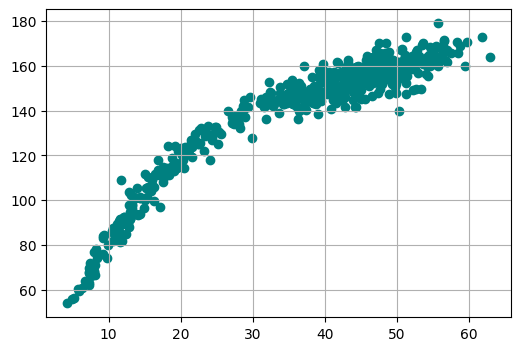

In [ ]:
!wget -O Howell1.csv https://raw.githubusercontent.com/deep-learning-indaba/indaba-pracs-2023/main/data/Howell1.csv

df = pd.read_csv('Howell1.csv', sep=";")
df.head()

# observed data
weight = df.weight.values
height = df.height.values

# data to make predictions for
weight_pred = jnp.array([45, 40, 65, 31, 53])

# plot the data
plt.figure(figsize=(6, 4))
plt.scatter(x='weight', y='height', data=df, color='teal')
plt.grid(0.3)

We will model it with a polynomial regression model of the form

$$y \sim N(\mu, \sigma^2),\\
\mu = b_0 + b_1 x+b_2x^{2}.$$

Here $y$ is the data we want to predict, $x$ is the predictor, $b_0$ is the bias , $b_1\ and\ b_2$ are the coefficients of first and second other respectively and $\sigma^2$ is variance.


In [ ]:
######## model
def model(weight=None, height=None):
    # priors
    b0 = numpyro.sample('b0', dist.Normal(120,50))
    b1 = numpyro.sample('b1', dist.Normal(0,1))
    b2=numpyro.sample('b2', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.HalfNormal(10.))

    # deterministic transformation
    mu = b0 + b1 * weight + b2*weight**2

    # likelihood: notice `obs=height`
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=height)

###### plotter
def plot_regression(x, y_mean, y_hpdi, height, ttl='Predictions with 89% CI)'):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    weight = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    ht = height[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(weight, mean, color='teal')
    ax.plot(weight, ht, 'o', color='orangered')
    ax.fill_between(weight, hpdi[0], hpdi[1], alpha=0.3, interpolate=True, color='teal')
    ax.set(xlabel='weight', ylabel='height', title=ttl);
    return ax

dict_keys(['b0', 'b1', 'b2', 'obs', 'sigma'])


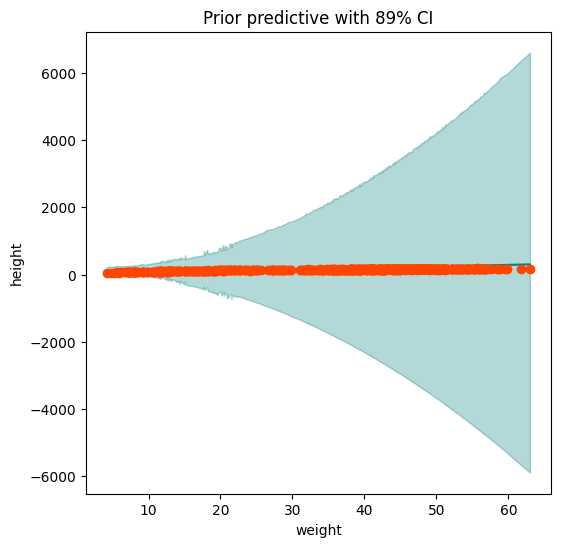

In [ ]:
#@title plot prior predictive distribution

# prior predictive
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, weight)
##
print(prior_predictions.keys())

## extract observations
pred_obs = prior_predictions['obs']
mean_prior_pred = jnp.mean(pred_obs, axis=0)
hpdi_prior_pred = hpdi(pred_obs, 0.89)

## plot
ax = plot_regression(weight, mean_prior_pred, hpdi_prior_pred, height, ttl="Prior predictive with 89% CI")

<ipython-input-109-d588bcb42287>:9: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, progress_bar=False)



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     46.03      1.19     46.01     44.10     48.01   2229.12      1.00
        b1      4.19      0.08      4.19      4.05      4.33   2199.79      1.00
        b2     -0.04      0.00     -0.04     -0.04     -0.04   2344.81      1.00
     sigma      5.77      0.18      5.77      5.47      6.05   2337.64      1.00

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     46.03      1.19     46.01     44.10     48.01   2229.12      1.00
        b1      4.19      0.08      4.19      4.05      4.33   2199.79      1.00
        b2     -0.04      0.00     -0.04     -0.04     -0.04   2344.81      1.00
     sigma      5.77      0.18      5.77      5.47      6.05   2337.64      1.00

Number of divergences: 0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


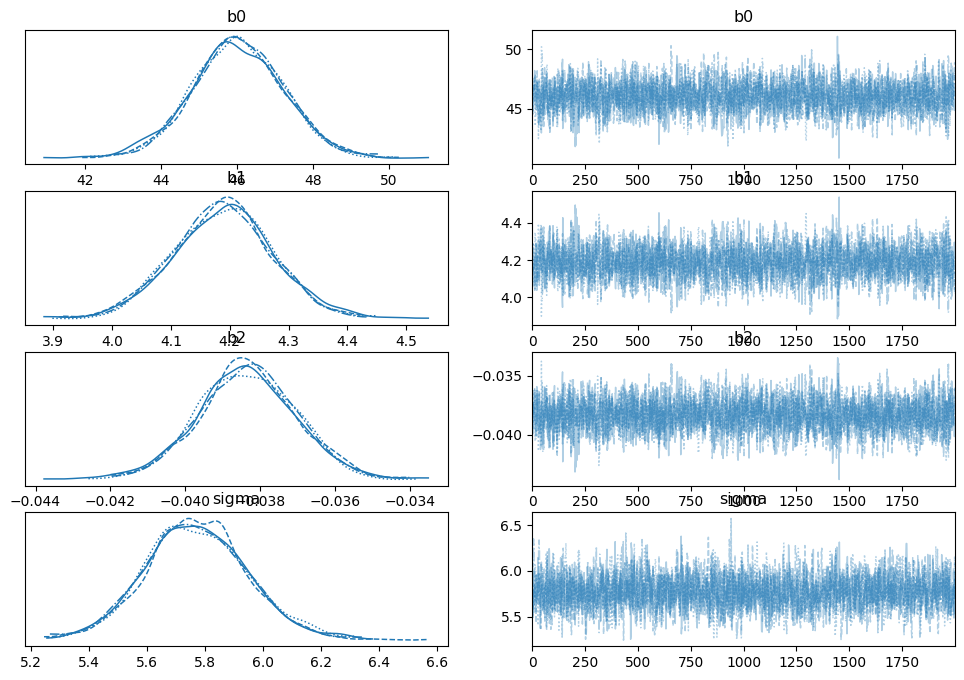

In [ ]:
#@title perform inference

# Inference
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4, progress_bar=False)
mcmc.run(rng_key_, weight=weight, height=height)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

# Check convergence
mcmc.print_summary()
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

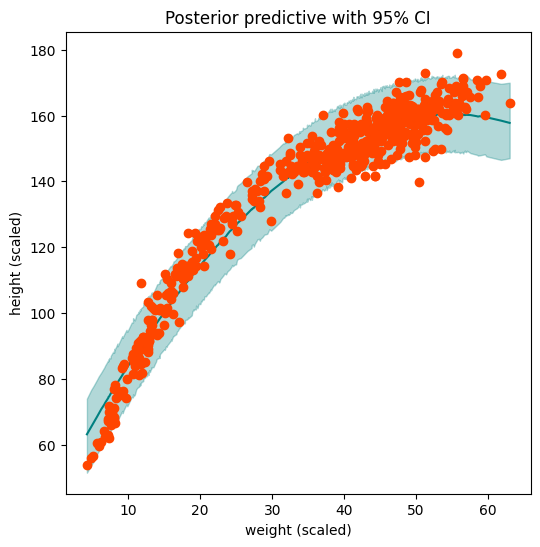

In [ ]:
#@title plot posterior predictive disitribution
# Posterior predictive
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
posterior_predictions = predictive(rng_key_, weight=weight)
post_obs = posterior_predictions['obs']

mean_post_pred = jnp.mean(post_obs, axis=0)
hpdi_post_pred = hpdi(post_obs, 0.95)

ax = plot_regression(weight, mean_post_pred, hpdi_post_pred, height, ttl="Posterior predictive with 95% CI")
ax.set(xlabel='weight (scaled)', ylabel='height (scaled)');